<div class="header" style="background-image: url('img/keyboard_opti_header.jpg');  background-position: right; width: 100%; height: 110px">
</div>


# ATH 2018: Keyboard Optimisation


In this notebook we learn about optimisation methods in HCI by applying them to a classic optimisation problem: keyboard layouting. We use this example to learn about the following aspects of computational interface design:
1. Formulating an HCI design problem as an optimisation problem.
2. Creating an appropriate objective function for our design goals.
3. Creating an optimiser to search the design space for a better design.

The figure shows the overall approach:

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto; max-width: 600px">
<img src="img/design_optimisation.png" style="padding-bottom: 1em; max-width: 600px"/>
User interface design as an optimisation problem. Given an objective function and task-specific parameters, an optimiser generates and evaluates designs from a design space to find a good or optimal design.
</div>


## Your task: beat QWERTY
You're most likely familiar with the QWERTY/QWERTZ layout. Using optimisation methods, you will design your own (even faster) layout.

We tackle this problem in two steps:

1. First, we formulate an appropriate **objective function**, including a model for estimating user performance. This allows us to estimate how fast users may type with a given keyboard layout (i.e. how "good" the layout is).

2. Second, we implement an **optimisation algorithm** that uses the objective function to find a good keyboard layout.


# Setup

We first import packages and setup useful methods and variables.

In [1]:
%load_ext autoreload
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML(open('css/notebook.html').read()))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import random
sns.set_context('notebook')

In [2]:
# Import methods for:
# - creating the key locations (Android-style keyboard)
# - plotting the keyboard
# - computing the distance between two keys
# - computing words per minute from the mean inter keypress time
from notebook_code.keyboard_optimisation import create_key_locations, plot_keyboard, wpm

In [4]:
# The character we want to assign to the keys (we limit this example to the alphabet; no numbers etc.):
characters = [c for c in 'abcdefghijklmnopqrstuvwxyz']
print characters

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
# The key locations:
key_locations = create_key_locations(key_w=1, key_h=1.5)
#print key_locations

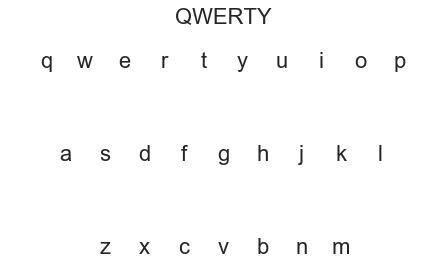

In [8]:
# As an example, we plot the QWERTY layout:
qwerty = [c for c in 'qwertyuiopasdfghjklzxcvbnm']
plot_keyboard(qwerty, key_locations, title='QWERTY')

# Objective function component 1: Finger movement model

When typing, we move fingers from one key to another. Here, we only look at typing with a single finger. This is a simplified but realistic case, for example when typing with the thumb or index finger on a smartphone.

## Fitts' law

To model finger movement times we use a famous model in HCI, Fitts' law:
$$MT = a + b \log_2{\left(\frac{D}{W}+1\right)}$$

It predicts the movement time $MT$ given the distance $D$ and target width $W$. The parameters $a$ and $b$ describe the relationship between the index of difficulty (the log term) and the movement time. Hence, Fitts' law intuitively models that hitting smaller targets at larger distances takes more time. Note that there are many variations and extensions of this law, so you might have come across slightly different formulations.

The parameter values for $a$ and $b$ are taken from the following paper, as well as the special case $a_{rep}$ when double-tapping the same key: <br/>
*Zhai, S., Hunter, M., & Smith, B. A. (2000). The metropolis keyboard - an exploration of quantitative techniques for virtual keyboard design. In Proceedings of the 13th annual ACM symposium on User interface software and technology (pp. 119–128). http://doi.org/10.1145/354401.354424*


<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise: Implement Fitts' law</h3> 
<br>
Implement Fitts' law by completing the code in the cell below. Use $a_{rep}$ instead of $a$ for the case of a double tap at the same key.</div>
</p>

Note that is a good example of how you can make direct use of models published in previous work as building blocks for your own optimisation.

In [10]:
def movement_time_from_key_to_key(i, j, D, W=1, a=0, b=0.204, arep=0.127):  
    mt = 0
    if i == j: # double tap on same key
        # TODO: implement Fitts' law for the double tap case
        mt = arep + b * math.log(D/W + 1, 2)
    else: # move from key i to key j
        # TODO: immplement Fitts' law
        mt = a + b * math.log(D/W + 1, 2)
    return mt

# Objective function component 2: Language model

Not every key is equally important, since natural languages use certain characters much more often than others. For example, the transition from key "t" to key "h" is very common in English, while a move like "c" to "x" will almost never occur at all.

We make use of these language properties by weighting the movement cost of each key-to-key transition by the relative frequency of the character combination of those two keys.

To do so, we use bigram frequencies taken from:
https://gist.github.com/lydell/c439049abac2c9226e53#file-bigrams-json

In [11]:
def create_bigram_language_model(text_file):
    bigram_data = pd.read_csv(text_file)
    language_model = {}
    total = 0
    for _, row in bigram_data.iterrows():
        language_model[row.bigram] = row.frequency
        total += row.frequency
    for key in language_model.iterkeys():
        language_model[key] /= total * 1.0
    return language_model

In [12]:
language_model = create_bigram_language_model('data/bigrams.csv')

In [13]:
# Print some examples of what the model has learned:
print 'th:', language_model['th'] # a common bigram -> should be a rather high value
print 'ql:', language_model['ql'] # a rare bigram -> should be a tiny value

th: 0.0357629921884
ql: 2.39277918371e-06


# Objective function

We now have the two components for our objective function: 1) the movement model, and 2) the frequency of said movements considering the language.

<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise: Implement the objective function</h3> 
<br>
Complete the code in the cell below to implement an objective function that returns the estimated average time between two key presses. Consider the movement times of all possible movements, each weighted by the bigram frequency for that character pair.</div>
</p>

In [14]:
# Measures the euclidean distance between two key locations:
def distance(key_location, key_location2):
    x,y = key_location
    x2,y2 = key_location2
    return np.sqrt((x-x2)**2 + (y-y2)**2)

# Objective function: returns the estimated average time between two key presses for the given layout:
def objective_function(layout, key_locations, language_model):
    objective_value = 0
    for i, character in enumerate(layout):
        for j, character2 in enumerate(layout):
            frequency = language_model[character+character2]# TODO: lookup frequency of this bigram in language model
            key_distance = distance(key_locations[i], key_locations[j])# TODO: compute the distance of the two key locations
            movement_time = movement_time_from_key_to_key(i, j, key_distance)# TODO: compute the movement time using Fitts' Law
            objective_value += frequency * movement_time # TODO: update objective value
    return objective_value

# Optimisation

With our objective function in place we now turn to the optimisation process.

## Baseline: QWERTY

Let's check how good the QWERTY layout is according to our objective function. We use this as a baseline: Can you find a faster layout?

In [15]:
%autoreload 2
qwerty_ov = objective_function(qwerty, key_locations, language_model)
qwerty_wpm = wpm(qwerty_ov)
print '%.2f words per minute (WPM) with the QWERTY layout.' % qwerty_wpm

28.43 words per minute (WPM) with the QWERTY layout.


## A simple optimiser: Random search

A very simple optimisation procedure is one that just generates random layouts in the hope of finding a better one. This idea is called "random search".

<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise: Implement a random search optimiser</h3> 
<br>
Complete the code in the cell below to implement a random search optimiser. Hint: <a href="https://docs.python.org/2/library/random.html#random.sample">random.sample(list, length)</a> is a useful function for shuffling lists. 
</div>
</p>

In [16]:
def random_search_optimiser(objective_function, layout, key_locations, language_model, max_iterations=1000):
    
    best_layout = layout
    best_objective_value = objective_function(layout, key_locations, language_model)
    
    for iteration in range(max_iterations):
        
        # Try out a new random layout:
        candidate = random.sample(layout, len(layout))# TODO: choose a random layout
        candidate_objective_value = objective_function(candidate, key_locations, language_model)# TODO: evaluate the candidate with the objective function
        
        # If we found a better layout than the best one so far, save it as the new best one:
        # TODO: implement updating the best layout/value
        if candidate_objective_value > best_objective_value:
            best_layout = candidate
            best_objective_value = candidate_objective_value
            
    return best_layout, best_objective_value

Now run the cell below and examine the keyboard that your random search has found. What's the predicted WPM?

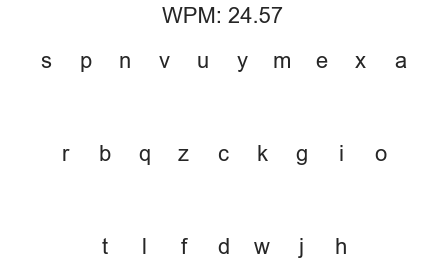

In [21]:
best_layout, best_ov = random_search_optimiser(
    objective_function, qwerty, key_locations, language_model, max_iterations=1000)
plot_keyboard(best_layout, key_locations, 'WPM: %.2f' % wpm(best_ov))

## Meta-heuristics: Simulated Annealing

Random search is limited. More effective and efficient methods use various **search heuristics**. Heuristics are still basically trial-and-error, but they try to implement a clever strategy instead of random choice. Many heuristics are inspired by natural processes or behaviour of animals. They model some tradeoff between **exploration** (try radically different designs) and **exploitation** (find the very best design). 

You can read more on these methods here: http://www.scholarpedia.org/article/Metaheuristic_Optimization

Here we take a look at one such method called **"Simulated Annealing"**. It is based on the process of shaping hot metals, which become less and less flexible as they cool down. Metaphorically, this optimisation procedure is also more flexible at the beginning (exploration), but focusses more and more on a specific area of the search space over time (exploitation).

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto">
<img src="img/annealing.jpg" style="max-width: 600px"/>
An iron smith shapes hot metal as HCI students shape future user interfaces. Image by <a href="https://flic.kr/p/5JXMsY">my_amii</a>, <a href="https://creativecommons.org/licenses/by-nc/2.0/">cc</a>.
</div>

<div class="alert alert-block alert-success"> 
<h3>Exercise: Implement Simulated Annealing</h3> 
<p>
Complete the code in the cell below to implement a Simulated Annealing optimiser. 
</p>

<p>
<h4>Step 1: Generating neighbour designs</h4>
First, generate a random neighbour design of the current layout. Layouts are "neighbours" if they only differ by one swap of keys. Use the provided swap_random_keys method. 
</p>

<p>
<h4>Step 2: Acceptance rule</h4>
Implement the following rule for accepting a candidate layout:
<ol>
<li>Accept the candidate layout if it is better than the current best layout.</li>
<li>Also accept a worse candidate layout with a chance $p$ based on the current "temperature": $p=\exp{\left(-\frac{\Delta E}{T}\right)}$ where $\Delta E$ is the difference of the objective value between the candidate layout and the best layout.</li>
</ol>
</p>
<p>
Some useful functions: you can use math.exp(x) for the exponential; random.random() generates a random number between 0 and 1,
</p>
</div>


In [23]:
# Returns a layout that is the same as the given one, apart from swapping two random keys:
def swap_random_keys(layout):
    layout = layout[:] # copy array
    i, j = np.random.choice(np.arange(len(layout)), size=2, replace=False)
    layout[i], layout[j] = layout[j], layout[i]
    return layout

def simulated_annealing_optimiser(objective_function, layout, key_locations, language_model, max_iterations=1000):
    
    # Hyperparameters of the optimiser:
    T_min = 0.0000001 # minimum temperature
    T_initial = 10000 # initial temperature
    alpha = 0.95 # cooling factor
    
    best_layout = layout
    best_objective_value = objective_function(layout, key_locations, language_model)
    
    for iteration in range(max_iterations):
        
        # Cooling down: update the current temperature
        T = max(T_min, T_initial * math.pow(alpha, iteration)) 
        
        # Step 1 - Generate a neighbour design by swapping one key:
        candidate = swap_random_keys(best_layout) # TODO
        candidate_objective_value = objective_function(candidate, key_locations, language_model)
        
        # Step 2 - Check if the candidate is better or if it is accepted by chance, based on the temperature:
        # TODO:
        delta = candidate_objective_value - best_objective_value
        if delta < 0 or random.random() < math.exp(-delta/T):
            best_layout = candidate
            best_objective_value = candidate_objective_value
            
    return best_layout, best_objective_value

Now run the cell below and examine the keyboard that your Simulated Annealing optimiser has found.

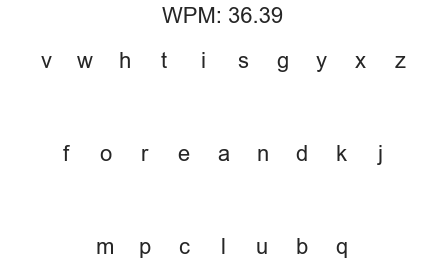

In [29]:
best_layout, best_ov = simulated_annealing_optimiser(
    objective_function, characters, key_locations, language_model, max_iterations=1000)
plot_keyboard(best_layout, key_locations, 'WPM: %.2f' % wpm(best_ov))

<div class="alert alert-block alert-info"> 
<h1>Discussion: Ideas for further improvements</h1>
<br/>
What's the predicted WPM now? Compare your results to random search. How could we improve this further?
</div>

# A new objective: layouts for one handed use of large mobile devices

Let us consider a different design objective now: **optimising the layout for typing with the right thumb** on a large smartphone or "phablet". This is a common hand posture used for typing on smartphones in everyday life, where just one hand might be free for interaction (e.g. while carrying groceries). However, on large screens reaching some keys may require shifting the grasp, which takes time and risks loosing the grip on the device.

In the cell below, we set up a slightly different objective function to address this task: It considers movement time and bigram frequency as before, but now also takes into account the **distance of each key to the bottom right corner**. This implements the intuitive idea of **minimising "thumb stretch time"** when typing with the right hand thumb.

Note that this is a simplified example, not entirely in line with [thumb ergonomics](http://users.comnet.aalto.fi/oulasvir/pubs/paper2117.pdf).

In [30]:
# Measures the euclidean distance between two key locations:
def distance_to_thumb_rest(key_location, thumb_rest_location):
    x,y = key_location
    x2,y2 = thumb_rest_location
    return np.sqrt((x-x2)**2 + (y-y2)**2)

# Objective function: returns the estimated average time between two key presses for the given layout:
def objective_function_thumb(layout, key_locations, language_model):
      
    # keyboard corners (if you have not changed the key size):
    # top left: 0,0 | top right: 9,0 
    # bottom left: 0,3 | bottom right: 9,3
    thumb_rest_location = [0,3]
    
    
    objective_value = 0
    for i, character in enumerate(layout):
        thumb_stretch = distance_to_thumb_rest(key_locations[i], thumb_rest_location)
        thumb_stretch_time = movement_time_from_key_to_key(0,1, thumb_stretch)
        for j, character2 in enumerate(layout):
            frequency = language_model[character+character2]
            key_distance = distance(key_locations[i], key_locations[j])
            movement_time = movement_time_from_key_to_key(i, j, key_distance)    
            objective_value += frequency * (movement_time + thumb_stretch_time)
    return objective_value

Now run the cell below:

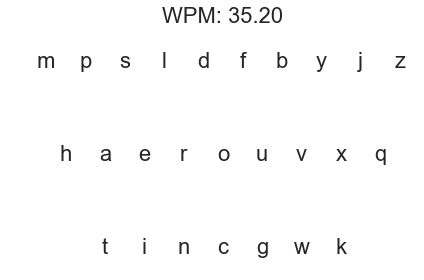

In [31]:
best_layout, best_ov = simulated_annealing_optimiser(
    objective_function_thumb, characters, key_locations, language_model, max_iterations=1000)

# We need to measure speed with the old objective function, 
# since the new one does not return the average time between two key presses:
best_layout_wpm = wpm(objective_function(best_layout, key_locations, language_model))
plot_keyboard(best_layout, key_locations, 'WPM: %.2f' % best_layout_wpm)

<div class="alert alert-block alert-info"> 
<h1>Discussion: layouts for one handed use</h1>
<br/>
How do these new layouts differ from the other ones obtained above? Which user behaviour is implicitly modelled in the new objective function? Think beyond this illustrative example: is this a good way of dealing with reachability problems on large screens?
<br/>
<br/>
**Optional**: Change the thumb's resting location in the objective function (e.g. for a left-handed user). How does that influence the layouts?
</div>

# Conclusion


In this notebook we learned about optimisation methods in HCI by applying them to the classic problem of keyboard layouting:

1. First, we formulated an **objective function**, considering finger movement times and character frequencies in the English language. This function thus estimated how fast users may type with a given keyboard layout. This was our measure of "goodness" for keyboard layouts

2. Second, we implemented two **optimisation algorithms** that used the objective function to find a good keyboard layout. We started with a very simple approach, random search, followed by a meta-heuristic approach called Simulated Annealing. This allowed us to find a new layout that was predicted to be faster than the common QWERTY layout.

<div class="alert alert-block alert-info"> 
<h1>Wrap-up</h1>
<br/>
Reflect on this session. What were the most surprising, challenging, useful or exciting things you learned? What should be changed to improve this session and notebook?
</div>

Feedback or comments? I'd love to hear from you! Get in touch at: daniel.buschek@ifi.lmu.de
